In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Constants and Parameters

Note that many of these parameters will be explicitly ignored / changed in the following experiments. These simply provide a baseline for future experiments.

In [2]:
TORCH_DEVICE = "cuda"

DATA_STEPS = 1000   # The number of time steps to simulate when creating the data. In practice this is defined by collection of data, not simulation.

USE_ADJOINT = True # Defines how to solve the ODE. Adjoint is typically more stable.
BATCH_SIZE = 20     # The number of samples to take in each batch. Defines the number of time intervals that are sampled for each batch of learning.
BATCH_TIME = 10     # Defines the length of each time interval for learning.
NUM_EPOCHS = 2000   # Number of epochs to train over
TEST_FREQUENCY = 20 # How many epochs between testing the network during training (mainly for visualization)
HIDDEN_LAYER_SIZE = 50  # Defines the (very simple) neural network architecture

if USE_ADJOINT:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

# Initial Example

### Differential Equation Definition

In [3]:
true_y0 = torch.tensor([[2., 0.]]).to(TORCH_DEVICE) # Define the true initial condition for the simulation. In practice, defined by data collection.
t = torch.linspace(0., 25., DATA_STEPS).to(TORCH_DEVICE)    # Define the time steps starting from the true_y0
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(TORCH_DEVICE) # Define the true matrix determining the differential equation. THIS IS WHAT WE ARE MODELLING!!!

# Define the differential equation of the system as a nn.Module for future integration in torch.
# 
# Interpret Lambda as dy/dt = f(t ,y) such that forward implements f(t, y)
class Lambda(nn.Module):
    
    def forward(self, t, y):
        return torch.mm(y**3, true_A)

In [4]:
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method="dopri5")

### Neural Network Setup

In [5]:
# Get a batch of data to train the neural network on
def get_batch():
    # First get a bunch of random start time indices. Note that we allow enough room for a full batch (defined by BATCH_TIME) at each choice.
    # s.shape = (BATCH_SIZE).
    s = torch.from_numpy(np.random.choice(np.arange(DATA_STEPS - BATCH_TIME, dtype=np.int64), BATCH_SIZE, replace=False))
    
    # Define the initial conditions for each start time choice.
    # batch_y0.shape = (BATCH_SIZE, *dimension)
    batch_y0 = true_y[s]

    # Get the time for the batch. Note that we use the same time frame for each initial condition, 
    # i.e. we are reframing the problem to start from t = 0. This is fine, just a shift of the time variable (?)
    # batch_t.shape = (BATCH_TIME)
    batch_t = t[:BATCH_TIME]

    # Get the true value of y for the batch. Collect the right intervals from true_y based on start time and BATCH_TIME.
    # batch_y.shape = (BATCH_TIME, BATCH_SIZE, *dimension)
    batch_y = torch.stack([true_y[s + i] for i in range(BATCH_TIME)], dim=0)  # (T, M, D)
    return batch_y0.to(TORCH_DEVICE), batch_t.to(TORCH_DEVICE), batch_y.to(TORCH_DEVICE)

In [ ]:
# Neural network that will learn the equation and dynamics
class ODEFunc(nn.Module):

    # Set up architecture just like any "normal" network
    def __init__(self):
        super(ODEFunc, self).__init__()

        # Input is defined by the number of measurements fed in 
        # e.g. [y**1, y**2, y**3, sin(y)] would be (4, *dimension) for y.shape = dimension
        # 
        # Output is simply y.shape = dimension
        # 
        # Hidden layer (may be many, but only one is required, and easy to interpret) can be small
        self.net = nn.Sequential(
            nn.Linear(2, HIDDEN_LAYER_SIZE),
            nn.Tanh(),
            nn.Linear(HIDDEN_LAYER_SIZE, 2),
        )

        # Initialization... is this useful? Required?
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    # Define forward based on the differential equation. If we *know* dy/dt only depends on the cube, this is fine... but how robust?
    def forward(self, t, y):
        return self.net(y**3)

### Training and Testing

In [8]:
func = ODEFunc().to(TORCH_DEVICE)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3) # Strange Optimizer... any reason for this choice?

for epoch in range(1, NUM_EPOCHS + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(TORCH_DEVICE) # See that we solve the ODE in the same way as simulation... but now use NN not simulation.
    loss = torch.mean(torch.abs(pred_y - batch_y)) # Loss is MAE? What about MSE?
    loss.backward()
    optimizer.step()

    if epoch % TEST_FREQUENCY == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print(f"Epoch {epoch:04d} | Total Loss {loss.item():.6f}", end="\r")
print()
with torch.no_grad():
    pred_A = func.forward(0, torch.eye(2).to(TORCH_DEVICE))
print(f"TRUE A:\n{true_A}")
print(f"PRED A:\n{pred_A}")

Epoch 2000 | Total Loss 0.308121
TRUE A:
tensor([[-0.1000,  2.0000],
        [-2.0000, -0.1000]], device='cuda:0')
PRED A:
tensor([[-0.1188,  1.9914],
        [-2.0443, -0.0940]], device='cuda:0')


# Overparameterize Network Inputs

What if we give the network *more* than just y**3? What if we present, say, the first five powers of y?

In [97]:
EXPONENT_COUNT = 5   # The number of powers of y to present. For example, DIMENSION = 3 corresponds to [y**1, y**2, y**3]
exponentVector = torch.arange(1,EXPONENT_COUNT+1).repeat_interleave(2).to(TORCH_DEVICE) # Note that the 2 comes from the dimension of y being 2

true_y0 = torch.tensor([[2., 0.]]).to(TORCH_DEVICE)
t = torch.linspace(0., 25., DATA_STEPS).to(TORCH_DEVICE)
# Note that now the inputs to the differential equation / network is represented by a vector corresponding to powers.
# For y = (y1, y2), the input is now (y1, y2, y1**2, y2**2, y1**3. y2**3, ...)
# So to encode the same example as above, start with an empty coefficient matrix and set the correct coefficients
true_A = torch.zeros(size=(2*EXPONENT_COUNT, 2)).to(TORCH_DEVICE)
true_A[4,:] = torch.tensor([-0.1, 2.0])
true_A[5,:] = torch.tensor([-2.0, -0.1])

# Here is a sanity check: 
# - the shape of y at any time (i.e. what our differential equation outputs) is (1, 2)
# - the shape of our network inputs (the powers of y) is (1, 2*POWERS)
# - the shape of our coefficient matrix A is (2*POWERS, 2)
# Hence, the multiplication of the tensor of inputs and the coefficient matrix will give the correct output
print(true_y0.shape, torch.pow(true_y0.tile(EXPONENT_COUNT), exponentVector).shape, true_A.shape)

# We update Lambda to use the powers of y in the forward pass
class Lambda(nn.Module):
    
    def forward(self, t, y):
        return torch.mm(torch.pow(y.tile(EXPONENT_COUNT), exponentVector), true_A)
    
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method="dopri5")

torch.Size([1, 2]) torch.Size([1, 10]) torch.Size([10, 2])


In [ ]:
# Batching remains the same

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(DATA_STEPS - BATCH_TIME, dtype=np.int64), BATCH_SIZE, replace=False))
    batch_y0 = true_y[s]
    batch_t = t[:BATCH_TIME]
    batch_y = torch.stack([true_y[s + i] for i in range(BATCH_TIME)], dim=0)  # (T, M, D)
    return batch_y0.to(TORCH_DEVICE), batch_t.to(TORCH_DEVICE), batch_y.to(TORCH_DEVICE)


# But network must now accept the correct number of inputs
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2*EXPONENT_COUNT, HIDDEN_LAYER_SIZE),
            nn.Tanh(),
            nn.Linear(HIDDEN_LAYER_SIZE, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(torch.pow(y.tile(EXPONENT_COUNT), exponentVector))

In [ ]:
func = ODEFunc().to(TORCH_DEVICE)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

for epoch in range(1, NUM_EPOCHS + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t).to(TORCH_DEVICE)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if epoch % TEST_FREQUENCY == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print(f"Epoch {epoch:04d} | Total Loss {loss.item():.6f}", end="\r")
print()
with torch.no_grad():
    pred_A = func.net(torch.eye(2*EXPONENT_COUNT).to(TORCH_DEVICE))
print(f"TRUE A:\n{true_A}")
print(f"PRED A:\n{pred_A}")

Epoch 2000 | Total Loss 0.698733
TRUE A:
tensor([[ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [-0.1000,  2.0000],
        [-2.0000, -0.1000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]], device='cuda:0')
PRED A:
tensor([[-0.0945,  2.0360],
        [-1.9657, -0.0423]], device='cuda:0')


### Visualization

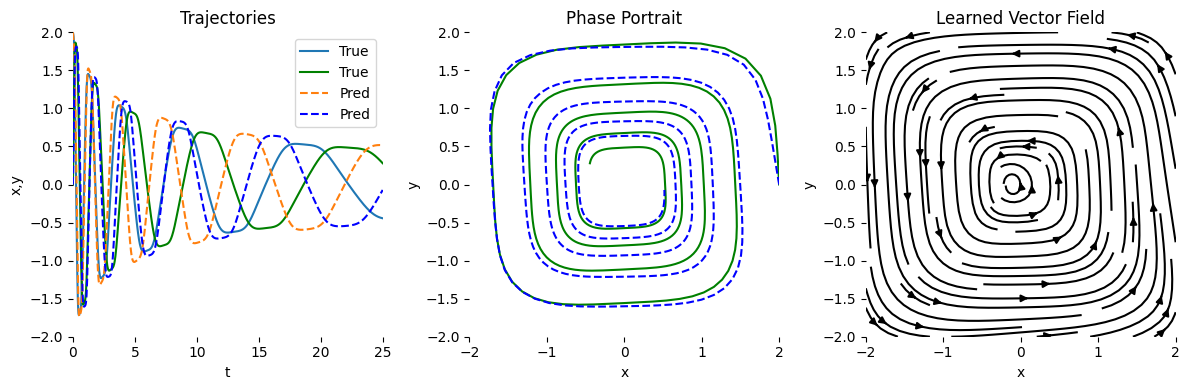

In [105]:
fig = plt.figure(figsize=(12, 4), facecolor='white')
ax_traj = fig.add_subplot(131, frameon=False)
ax_phase = fig.add_subplot(132, frameon=False)
ax_vecfield = fig.add_subplot(133, frameon=False)

ax_traj.set_title('Trajectories')
ax_traj.set_xlabel('t')
ax_traj.set_ylabel('x,y')
ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'g-', label="True")
ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 0], '--', t.cpu().numpy(), pred_y.cpu().numpy()[:, 0, 1], 'b--', label="Pred")
ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
ax_traj.set_ylim(-2, 2)
ax_traj.legend()

ax_phase.set_title('Phase Portrait')
ax_phase.set_xlabel('x')
ax_phase.set_ylabel('y')
ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
ax_phase.plot(pred_y.cpu().numpy()[:, 0, 0], pred_y.cpu().numpy()[:, 0, 1], 'b--')
ax_phase.set_xlim(-2, 2)
ax_phase.set_ylim(-2, 2)

ax_vecfield.set_title('Learned Vector Field')
ax_vecfield.set_xlabel('x')
ax_vecfield.set_ylabel('y')

y, x = np.mgrid[-2:2:21j, -2:2:21j]
dydt = func(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(TORCH_DEVICE)).cpu().detach().numpy()
mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
dydt = (dydt / mag)
dydt = dydt.reshape(21, 21, 2)

ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
ax_vecfield.set_xlim(-2, 2)
ax_vecfield.set_ylim(-2, 2)

fig.tight_layout()
plt.show()